# Age recognition 

**Authors**: Richard Šléher, Tomáš Majerník

**Dataset**: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/code?select=train.csv

# TODO
- wandb
- hyperparameter tuning (sweep)

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from summarytools import dfSummary
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score
import torch.nn as nn
import torch.nn.functional as F


Hyperparameters

In [2]:
IMAGE_SIZE = 128

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


## EDA

In [4]:
data = pd.read_csv('data/train.csv')

In [5]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9896.jpg2. 377.jpg3. 7038.jpg4. 10812.jpg5. 11803.jpg6. 22630.jpg7. 9733.jpg8. 6149.jpg9. 10025.jpg10. 14939.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)19,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"10,804 (54.3%)6,706 (33.7%)2,396 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


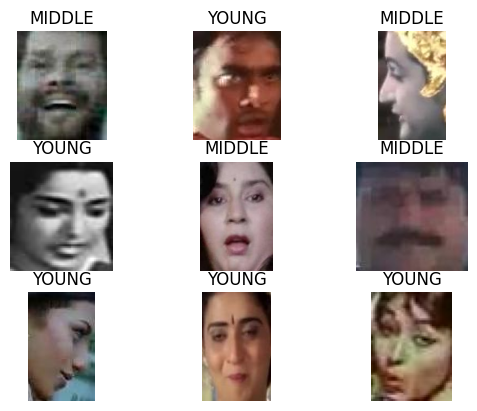

In [6]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread('data/train/' + data.iloc[i]['ID'])
    plt.imshow(img)
    plt.title(data.iloc[i]['Class'])
    plt.axis('off')

plt.show()

In [7]:
sampled_data = data.groupby('Class').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)
remaining_data = data.drop(sampled_data.index)
val_data = remaining_data.groupby('Class').apply(lambda x: x.sample(n=1000)).reset_index(drop=True)

print(f"Training data size: {sampled_data.shape}")
print(f"Validation data size: {val_data.shape}")

Training data size: (6000, 2)
Validation data size: (3000, 2)


C:\Users\risko\AppData\Local\Temp\ipykernel_11860\3112393278.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('Class').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)
C:\Users\risko\AppData\Local\Temp\ipykernel_11860\3112393278.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_data = remaining_data.groupby('Class').apply(lambda x: x.sample(n=1000)).reset_index(d

In [8]:
dfSummary(sampled_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 18474.jpg2. 13334.jpg3. 9365.jpg4. 14486.jpg5. 6600.jpg6. 22085.jpg7. 4031.jpg8. 24083.jpg9. 21301.jpg10. 16370.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)5,990 (99.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. OLD3. YOUNG,"2,000 (33.3%)2,000 (33.3%)2,000 (33.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABZUlEQVR4nO3bQWrCYBSF0ZcSSp0kBMHFuIgutovIbkT8B23pJB10aGeV+4s9ZwVP+FAiucO2bQUJT70P4P8YqmpXVc+9D7mhr23bPnofwbVxv9+/TtO09D7kVlpr52EY3gR3f8Zpmpbj8fgxz/Nn72P+6nK5vKzrupxOp+eqEtudGauq5nn+PBwO772PuZFd7wP4nQcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSMVT/vgfU+5BYe5XM8qrG1dl7XdakHeQ+stXauqq/ed3DNBoGYwZSPFN9sxFhXEWNdRYx1FTH+1CVGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjHUVMdZVxNggEGNdRYwHBGL8jBJjykeMKR8xpnzEeEAgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERowpHzGmfMTYIBBjykfMN77xo0reSBZ8AAAAAElFTkSuQmCC"">",0(0.0%)


In [9]:
dfSummary(val_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 6042.jpg2. 21249.jpg3. 2871.jpg4. 2550.jpg5. 19875.jpg6. 23558.jpg7. 16036.jpg8. 2825.jpg9. 15496.jpg10. 16288.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)2,990 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Class[object],1. MIDDLE2. OLD3. YOUNG,"1,000 (33.3%)1,000 (33.3%)1,000 (33.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABZUlEQVR4nO3bQWrCYBSF0ZcSSp0kBMHFuIgutovIbkT8B23pJB10aGeV+4s9ZwVP+FAiucO2bQUJT70P4P8YqmpXVc+9D7mhr23bPnofwbVxv9+/TtO09D7kVlpr52EY3gR3f8Zpmpbj8fgxz/Nn72P+6nK5vKzrupxOp+eqEtudGauq5nn+PBwO772PuZFd7wP4nQcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSMVT/vgfU+5BYe5XM8qrG1dl7XdakHeQ+stXauqq/ed3DNBoGYwZSPFN9sxFhXEWNdRYx1FTH+1CVGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjHUVMdZVxNggEGNdRYwHBGL8jBJjykeMKR8xpnzEeEAgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERowpHzGmfMTYIBBjykfMN77xo0reSBZ8AAAAAElFTkSuQmCC"">",0(0.0%)


In [10]:
class AgeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2} 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join('data/train/', self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        label = self.label_mapping[label]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

train_dataset = AgeDataset(dataframe=sampled_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=(32), shuffle=True)

val_dataset = AgeDataset(dataframe=val_data, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=(32), shuffle=False)


## Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1, padding=2)  # Output: 6x128x128
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: 6x64x64
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)  # Output: 16x60x60
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Output: 16x30x30
        self.fc1 = nn.Linear(16 * 30 * 30, 120)  # Adjusted for 128x128 input
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 30 * 30)  # Adjusted for 128x128 input
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [12]:
model = CNN(in_channels=3, num_classes=3)

In [ ]:
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    return val_loss / len(val_loader), accuracy, precision, recall

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1e-2)

# Training loop
model.to(device)

train_losses = []
val_losses = []
val_accuracies = []
num_epochs = 35

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss, val_accuracy, precision, recall = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, \
           Val Accuracy: {val_accuracy:.3f}%, Precision: {precision:.3f}, Recall: {recall:.3f}')

Epoch 1/35, Loss: 1.101, Val Loss: 1.094, Val Accuracy: 38.767%
Epoch 2/35, Loss: 1.069, Val Loss: 1.017, Val Accuracy: 48.733%
Epoch 3/35, Loss: 1.006, Val Loss: 0.995, Val Accuracy: 49.967%
Epoch 4/35, Loss: 0.979, Val Loss: 0.969, Val Accuracy: 52.300%
Epoch 5/35, Loss: 0.958, Val Loss: 0.942, Val Accuracy: 55.567%
Epoch 6/35, Loss: 0.938, Val Loss: 0.919, Val Accuracy: 56.733%
Epoch 7/35, Loss: 0.920, Val Loss: 0.877, Val Accuracy: 60.167%
Epoch 8/35, Loss: 0.907, Val Loss: 0.887, Val Accuracy: 58.400%
Epoch 9/35, Loss: 0.880, Val Loss: 0.851, Val Accuracy: 60.667%
Epoch 10/35, Loss: 0.863, Val Loss: 0.840, Val Accuracy: 62.567%
Epoch 11/35, Loss: 0.855, Val Loss: 0.831, Val Accuracy: 62.400%
Epoch 12/35, Loss: 0.833, Val Loss: 0.821, Val Accuracy: 63.767%
Epoch 13/35, Loss: 0.828, Val Loss: 0.805, Val Accuracy: 64.500%
Epoch 14/35, Loss: 0.828, Val Loss: 0.808, Val Accuracy: 64.100%
Epoch 15/35, Loss: 0.808, Val Loss: 0.794, Val Accuracy: 64.933%
Epoch 16/35, Loss: 0.797, Val Loss

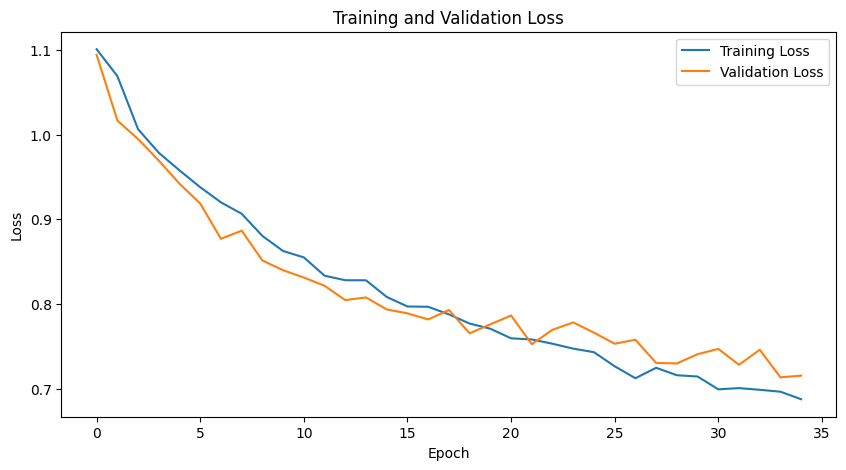

In [15]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

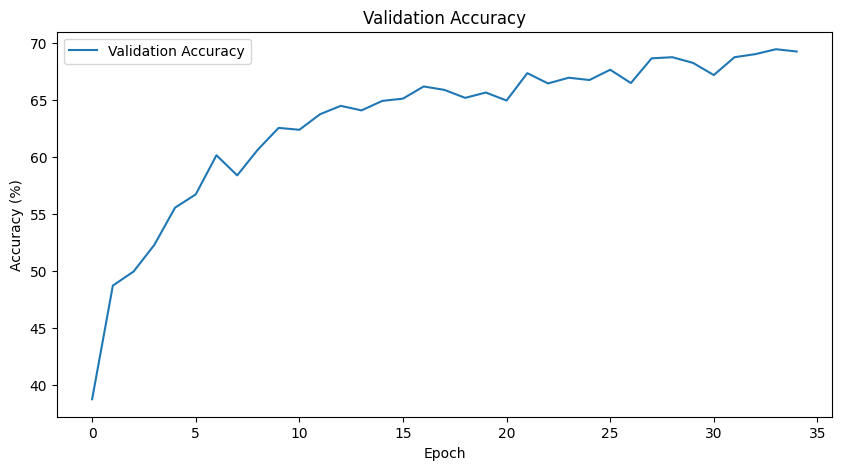

In [16]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [17]:
torch.save(model.state_dict(), 'age_recognition_model.pth')